In [18]:
import pandas as pd
import json
import os

import math

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
DATA_PATH = os.path.expanduser("~/data")

In [4]:
flags = pd.read_json("{}/scripts-6g/table_flag.json".format(DATA_PATH))

In [4]:
flags.columns.values

array([u'flag-any', u'flag-easylist', u'flag-easyprivacy',
       u'flag-fanboy-annoyance', u'flag-fanboy-social', u'inline', u'sha',
       u'url'], dtype=object)

In [5]:
flags.index = flags.sha

In [6]:
class ASTSampler:
    def __init__(self, flags, flag_type="flag-any", count=5000):
        self.flags = flags # pandas df
        self._flag_type = flag_type
        self._count = count
        self._asts = [[], []]
        
    def sample(self, iter_ast):
        for id, ast in iter_ast:
            if not id in self.flags.index:
                continue
            flag_value = flags.loc[[id]][self._flag_type]
            if len(flag_value) > 1:
                continue
            else:
                flag_value = int(flag_value)
            asts = self._asts[flag_value]
            if len(asts) >= self._count:
                continue
            asts.append(json.loads(ast))
            if len(self._asts[0]) >= self._count and len(self._asts[1]) >=self._count:
                return
    @property
    def positive(self):
        return self._asts[1]
    @property
    def negative(self):
        return self._asts[0]

In [7]:
sampler = ASTSampler(flags, count=500)

In [8]:
with open("{}/ast-10k.jsonl".format(DATA_PATH)) as f:
    raw_asts = (entry.split("\t") for entry in f.readlines())
    sampler.sample(raw_asts)

In [90]:
def count_node(ast):
    count = 0
    if isinstance(ast, dict):
        if "type" in ast:
            count = count + 1
        for v in ast.itervalues():
            count = count + count_node(v)
    elif isinstance(ast, list):
        for v in ast:
            count = count + count_node(v)
    
    return count

def get_types_distinct(ast, types=set()):
    if isinstance(ast, dict):
        if "type" in ast:
            types.add(ast['type'])
        for v in ast.itervalues():
            get_types_distinct(v, types)
    elif isinstance(ast, list):
        for v in ast:
            get_types_distinct(v, types)
    return types

def get_types(ast, types=[]):
    if isinstance(ast, dict):
        if "type" in ast and ast['type'] != 'Program':
            types.append(ast['type'])
        for v in ast.itervalues():
            get_types(v, types)
    elif isinstance(ast, list):
        for v in ast:
            get_types(v, types)
    return types

def count_type(ast):
    if isinstance(ast, dict):
        if "type" in ast:
            yield ast['type'], 1
        for v in ast.itervalues():
            for x in count_type(v):
                yield x
    elif isinstance(ast, list):
        for v in ast:
            for x in count_type(v):
                yield x

In [10]:
all_types = set()
for a in sampler.positive:
    get_types_distinct(a, all_types)
for a in sampler.negative:
    get_types_distinct(a, all_types)

In [11]:
len(all_types)

39

In [12]:
def get_types(asts):
    for a in asts:
        for t, _ in count_type(a):
            if t != 'Program':
                yield {"type":t}
        
pos_types = pd.DataFrame( get_types(sampler.positive) )
neg_types = pd.DataFrame( get_types(sampler.negative) )
pos_types['flag'] = 1
neg_types['flag'] = 0

In [28]:
type_entries = pd.concat([pos_types, neg_types])

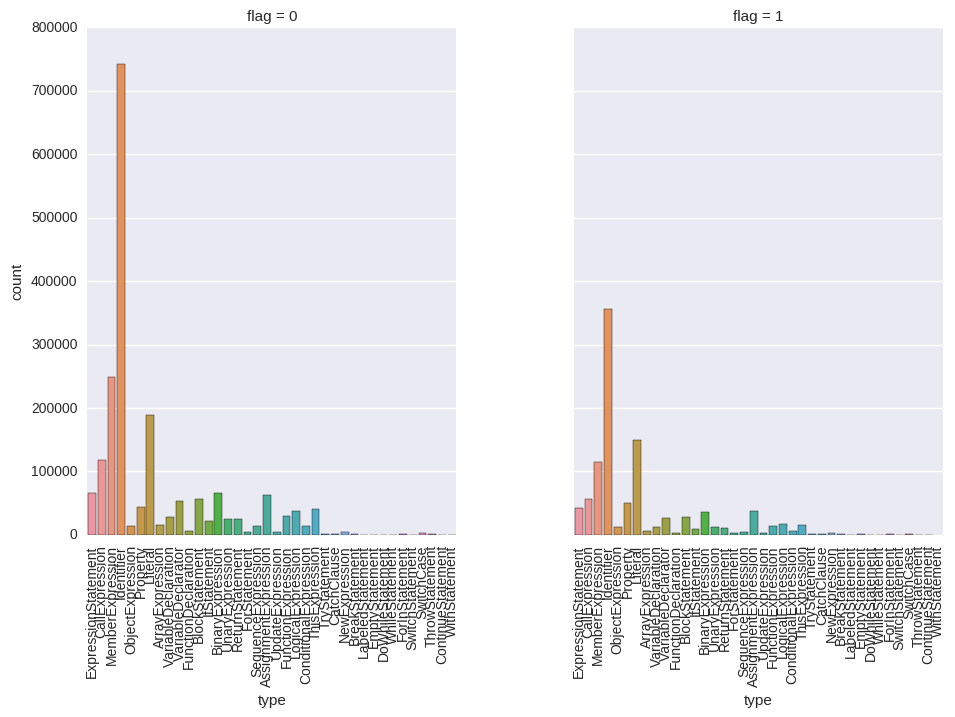

In [48]:

g = sns.factorplot("type", col="flag", col_wrap=4,
                    data=type_entries,
                    sharey=True, margin_titles=True,
                    kind="count", size=6, aspect=.8)
# g.fig.suptitle("Count Distribution of AST Node Types")
g.set_xticklabels(rotation=90)

In [71]:
pos_counts = [math.log(count_node(a)) for a in sampler.positive]
neg_counts = [math.log(count_node(a)) for a in sampler.negative]

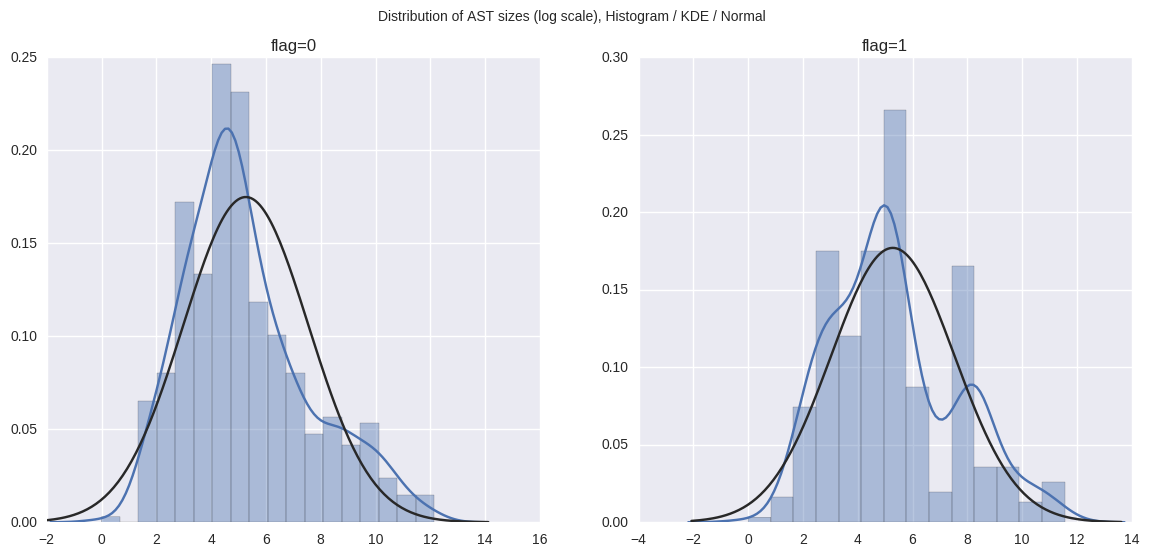

In [73]:
from scipy.stats import norm
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
g1 = sns.distplot(neg_counts, ax=ax1, fit=norm, norm_hist=True)
g1.set_title("flag=0")
g2 = sns.distplot(pos_counts, ax=ax2, fit=norm, norm_hist=True)
g2.set_title("flag=1")
fig.suptitle("Distribution of AST sizes (log scale), Histogram / KDE / Normal")

In [74]:
pos_counts = [count_node(a) for a in sampler.positive]
neg_counts = [count_node(a) for a in sampler.negative]

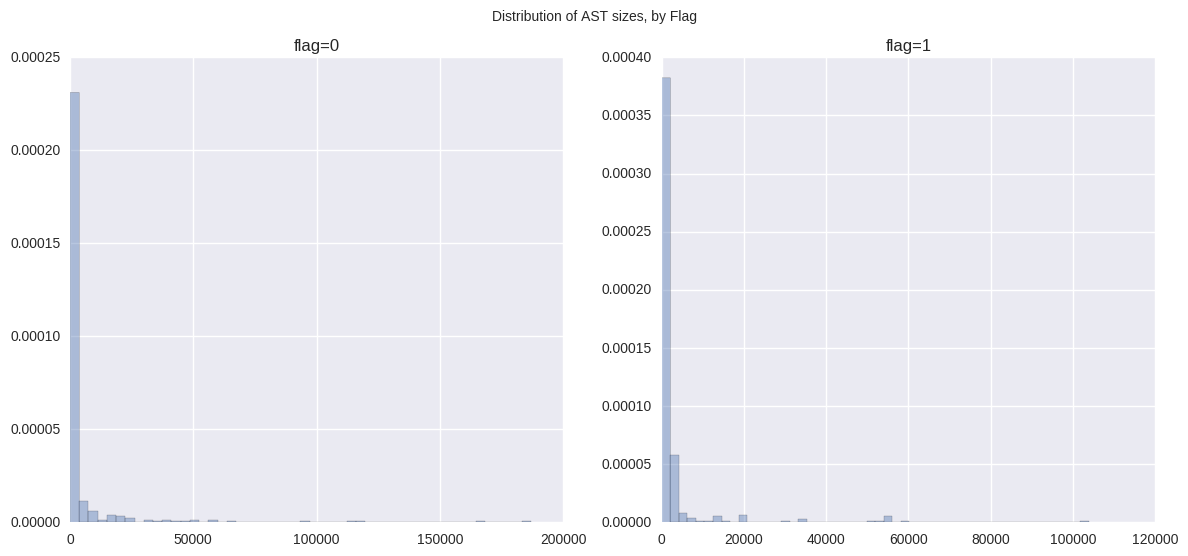

In [75]:
from scipy.stats import lognorm

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
g1 = sns.distplot(neg_counts, ax=ax1, norm_hist=True, kde=False)
g1.set_title("flag=0")
g2 = sns.distplot(pos_counts, ax=ax2, norm_hist=True, kde=False)
g2.set_title("flag=1")
fig.suptitle("Distribution of AST sizes, by Flag")

In [121]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE

In [91]:
pos_types = [" ".join(get_types(a, [])) for a in sampler.positive]
neg_types = [" ".join(get_types(a, [])) for a in sampler.negative]

In [194]:
count_vectorizer = CountVectorizer()
sizes = count_vectorizer.fit_transform(pos_types + neg_types)

In [112]:
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(pos_types + neg_types)

In [116]:
Y = np.zeros(dtype=np.int32, shape=[X.shape[0]])

In [117]:
Y[:len(pos_types)] = 1

In [133]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_x = tsne.fit_transform(X.todense())

In [195]:
sizes = np.sum(sizes.toarray(), axis=1).reshape((sizes.shape[0])).astype("float32")

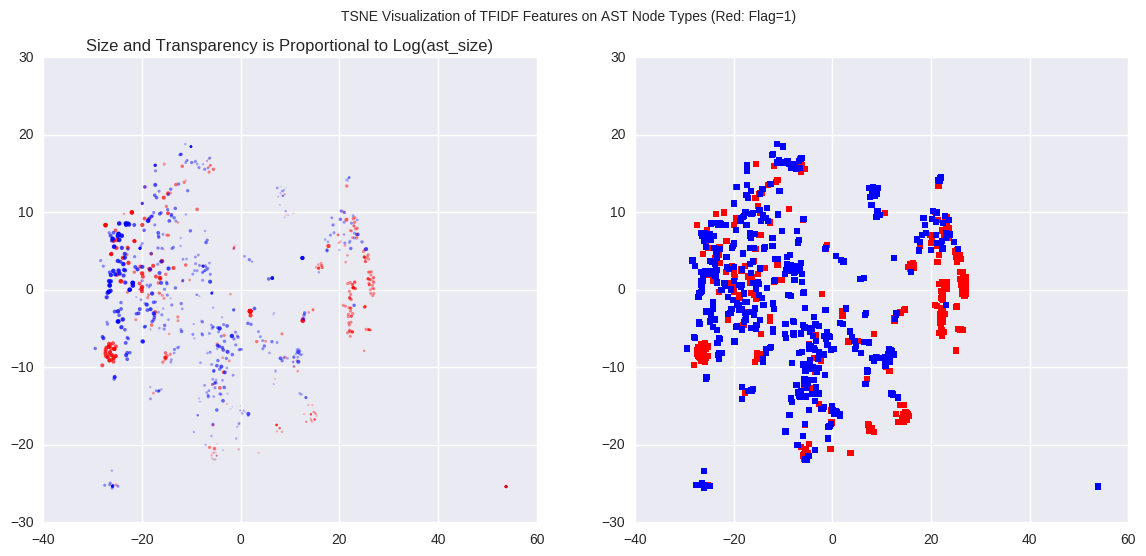

In [217]:
npos = len(pos_types)
n = len(sizes)

logsize = np.log(sizes + 1.0)
alphas = (logsize - np.min(logsize)) / (np.max(logsize) - np.min(logsize))

rgba_colors = np.zeros((n,4))
# for red the first column needs to be one
rgba_colors[:npos,0] = 1.0
rgba_colors[npos:,2] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:,3] = alphas
rgb_colors = rgba_colors.copy()
rgb_colors[:,3] = 1.0

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.scatter(*low_dim_x.T, c=rgba_colors, s=logsize, marker='o', linewidths=0)
ax1.set_title("Size and Transparency is Proportional to Log(ast_size)")
ax2.scatter(*low_dim_x.T, c=rgb_colors, marker='s', linewidths=0)
plt.suptitle("TSNE Visualization of TFIDF Features on AST Node Types (Red: Flag=1)")

In [219]:
from sklearn.neighbors import KNeighborsClassifier

In [223]:
indices = np.random.permutation(X.shape[0])
itrain, itest = indices[:600], indices[600:]
x_train, x_test = X[itrain], X[itest]
y_train, y_test = Y[itrain], Y[itest]

In [224]:
model = KNeighborsClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.78832116788321172